# Overwatch Data Visualization

Before running any statistical analysis on the data, it is usually a good idea to explore and visualize the dataset. This helps us get a general sense of data patterns, which can help generate hypotheses that can then be tested with more formal statistical models.

This notebook serves more as the beginnings of an exploratory data analysis, demonstrating how matplotlib can be used to answer specific research questions, rather than an in-depth analysis of the data.

## Imports

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load data

In [2]:
df = pd.read_csv('../data/all_seasons.csv')
df.tail(10)

,season,Game #,Start SR,End SR,SR Change,Team SR avg,Enemy SR avg,Team Stack,Enemy Stack,Role 1,...,Obj_time_career,Obj_time_medal,Dmg,Dmg_career,Dmg_medal,Heal,Heal_career,Heal_medal,Death,Death_career
473,9,305,2435,2453,18.0,2386,2402,2.0,2.0,Tank,...,01:35,Gold,8117.0,4916.0,None,0.0,6067.0,None,13.0,7.26
474,9,306,2453,2480,27.0,2545,2538,2.0,2.0,Support,...,01:35,Gold,5045.0,4916.0,None,6426.0,6067.0,Silver,4.0,7.25
475,9,307,2480,2503,23.0,P,P,2.0,2.0,Tank,...,01:35,Bronze,6011.0,4920.0,None,0.0,6048.0,None,9.0,7.25
476,9,308,2503,2482,-21.0,2479,2477,1.0,1.0,Tank,...,01:35,Gold,8421.0,4926.0,Bronze,0.0,6028.0,None,12.0,7.26
477,9,309,2482,2456,-26.0,2447,2457,2.0,2.0,Support,...,01:35,Bronze,3378.0,4915.0,None,9435.0,6029.0,Silver,19.0,7.28
478,9,310,2456,2480,24.0,2476,2481,2.0,2.0,Support,...,01:35,Silver,1770.0,5366.0,None,8639.0,8466.0,Silver,3.0,6.57
479,9,311,2480,2457,-23.0,2477,2484,2.0,3.0,Tank,...,01:36,Bronze,9571.0,4911.0,None,300.0,6010.0,None,11.0,7.27
480,9,312,2457,2480,23.0,2465,2466,2.0,2.0,Support,...,01:36,None,9473.0,4914.0,None,14859.0,6023.0,Silver,9.0,7.26
481,9,313,2480,2456,-24.0,2471,2471,2.0,1.0,Support,...,01:36,None,2369.0,4914.0,None,3280.0,6024.0,Silver,4.0,7.26
482,9,314,2456,2428,-28.0,2469,2449,3.0,4.0,Tank,...,01:36,Silver,2335.0,4909.0,None,0.0,6010.0,None,8.0,7.27


## Is there performance improvement over time?

To identify whether there is improvement over time, we can simply plot skill rating (SR) over time for each season. We can either use a `groupby` and create a plot for each season, or plot all seasons on the same graph (which I'll show here). Pandas offers some plotting tools, e.g. `df.groupby('season').plot('Game #', 'End SR')`, but I generally find I have much more control when using matplotlib directly.

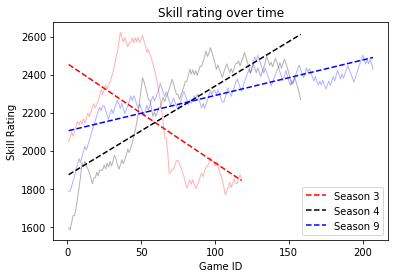

In [3]:
# Reset game number for season 9.
# It would be faster to use range() to create the new Game numbers, but there might be instances where games were skipped/not recorded
df.update(df.loc[df['season']==9, 'Game #'] - df.loc[df['season']==9, 'Game #'].min() + 1)

colours = ['r', 'k', 'b']

fig, ax = plt.subplots(nrows=1, ncols=1)
for s, c in zip(df['season'].unique(), colours):
    x = df[df['season'] == s]['Game #']
    y = df[df['season'] == s]['End SR']
    
    ax.plot(x, y, color=c, alpha=0.3, linewidth=1, label='')
    
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color=c, label='Season {}'.format(s), linestyle='--')

ax.set_xlabel('Game ID')
ax.set_ylabel('Skill Rating')
plt.title('Skill rating over time')
plt.legend()
plt.show()

A linear fit is likely not the most appropriate here, but it's good enough for approximating a crude trend. Clearly I went on a crazy losing streak in Season 3, but Seasons 4 and 9 generally show improvement over time. It makes sense that improvement in Season 9 was not as rapid as Season 4, as I had just returned to the game after a long break and was trying to find my footing again (new characters, new maps etc.)

## Which role do I perform the best on?

When it comes to role selection, I usually fill when playing ranked, and that mostly means I end up playing support or tank. So first, we should see how many times I played each role, and then look at win percentage per role.

*Note:* role data was only available in Season 9

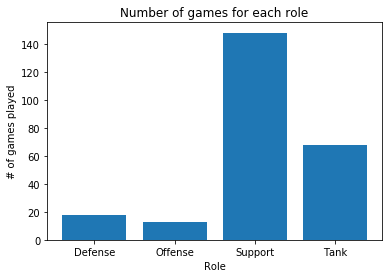

In [4]:
# get roles counts, even if there were multiple per game
role1_counts = df[df['season'] == 9]['Role 1'].value_counts()
role2_counts = df[df['season'] == 9]['Role 2'].value_counts()

role_counts = role1_counts + role2_counts

plt.bar(role_counts.index, role_counts)
plt.xlabel('Role')
plt.ylabel('# of games played')
plt.title('Number of games for each role')
plt.show()

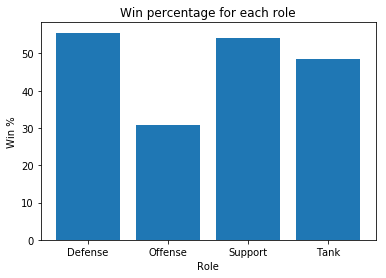

In [5]:
r1 = df[df['Role 1'].notnull()][['Role 1', 'Result']].rename(columns={'Role 1': 'Role'})
r2 = df[df['Role 2'].notnull()][['Role 2', 'Result']].rename(columns={'Role 2': 'Role'})
win_loss = r1.append(r2)

xtab = pd.crosstab(win_loss['Role'], win_loss['Result']).apply(lambda r: r/r.sum(), axis=1)

plt.bar(xtab.index, xtab['Win']*100)
plt.xlabel('Role')
plt.ylabel('Win %')
plt.title('Win percentage for each role')
plt.show()

Suspicion confirmed: filling means playing support or tank. My highest win rate comes from playing the Defense role (mostly Junkrat), although the win % is biased due to the low number of total games played in that role. This is followed closely by playing Support, and the win % is more stable due to the larger number of games (owing to my new-found obsession with playing Moira). These ~50% win rates are in line with what Blizzard tries to enforce with their matchmaking.

## Which game mode/map takes the longest to complete?

Do certain game modes take longer to play than others? And which specific map, within each game mode, takes the longest? To answer this, we first need to take the `Match Time` variable (which was only available for Season 9) and convert it minutes for easier plotting.

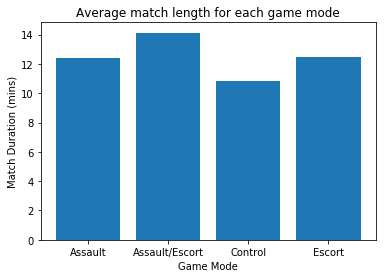

In [6]:
# convert match time to minutes
df['match_time_split'] = df['Match Time'].str.split(':')
mins = df[df['match_time_split'].notnull()]['match_time_split'].str[0].astype(float)
secs = (df[df['match_time_split'].notnull()]['match_time_split'].str[1].astype(float)/60)
df['match_mins'] = mins + secs

mode_time = df[['Map', 'Mode', 'match_mins']].groupby('Mode').mean()

plt.bar(mode_time.index, mode_time['match_mins'])
plt.title('Average match length for each game mode')
plt.xlabel('Game Mode')
plt.ylabel('Match Duration (mins)')
plt.show()

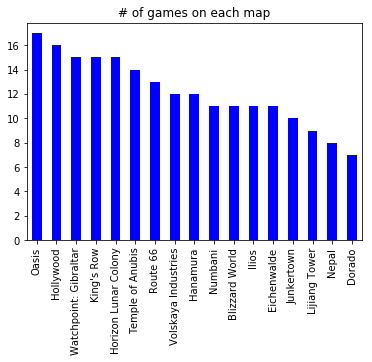

In [7]:
df['Map'].value_counts().plot(kind='bar', color='b', title='# of games on each map')

There is generally a pretty good distribution of maps, although some of the maps (e.g. Dorado, Nepal) didn't come up very often. I would have thought there'd be a more uniform distribution of maps - this is a good candidate for a Chi-square test to check the likelihood of getting a distribution like this

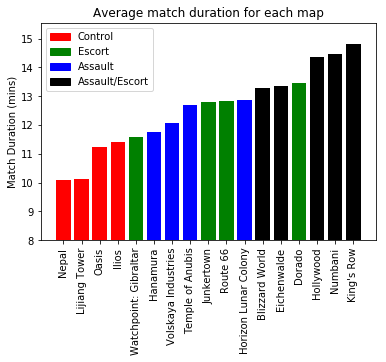

In [8]:
map_time = df[['Map', 'Mode', 'match_mins']].groupby(['Map','Mode']).mean().reset_index()
map_time = map_time.sort_values('match_mins').reset_index(drop=True)
map_time['color'] = map_time['Mode'].replace({'Control': 'r',
                                              'Escort': 'g',
                                              'Assault': 'b',
                                              'Assault/Escort': 'k'})

ind = range(len(map_time['Map'].unique()))

plt.bar(ind, map_time['match_mins'], color=map_time['color'])

c = mpatches.Patch(color='r', label='Control')
e = mpatches.Patch(color='g', label='Escort')
a = mpatches.Patch(color='b', label='Assault')
ae = mpatches.Patch(color='k', label='Assault/Escort')

plt.legend(handles=[c,e,a,ae], loc=2)
plt.xticks(ind, map_time['Map'], rotation='vertical')
plt.ylim(8,)
plt.ylabel('Match Duration (mins)')
plt.title('Average match duration for each map')

plt.show()

There is quite a range in game durations across the different maps, with Control maps (e.g. Nepal, Lijiang Tower) generally finishing faster than Assault/Escort maps (e.g. King's Row, Numbani). Within each game mode, Escort maps seem to have the largest variability, with Watchpoint: Gilbraltar having a game time (almost) as short as some Control maps, and Dorado taking longer than some of the Assault/Escort maps.

## Which game mode has a higher win percentage?

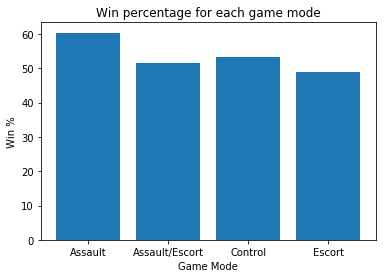

In [9]:
xtab = pd.crosstab(df['Mode'], df['Result']).apply(lambda r: r/r.sum(), axis=1)

plt.bar(xtab.index, xtab['Win']*100)
plt.xlabel('Game Mode')
plt.ylabel('Win %')
plt.title('Win percentage for each game mode')
plt.show()

Most game modes have around 50% win rate (as expected), but Assault maps (e.g. Hanamura) have a slightly higher win percentage at slightly over 60%.


## Does SR gain correlate with the SR difference between my team and the enemy team?


If we win a game, we would expect to gain more SR if the enemy team has a higher average team SR (i.e. we won against a better team), and vice versa. To check this, we can plot the SR difference between the two teams against the SR gain after a win or loss.

Note: `np.polyfit` doesn't handle missing data very well, so we need to grab only the rows where both variables of interest have valid values

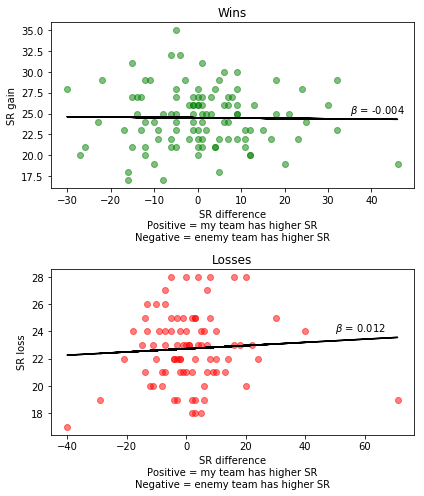

In [10]:
df['Team SR avg'] = df['Team SR avg'].replace({'P': np.nan}).astype(float)
df['Enemy SR avg'] = df['Enemy SR avg'].replace({'P': np.nan}).astype(float)
df['SR diff'] = df['Team SR avg'] - df['Enemy SR avg']

cur_df = df[df['season']==9]
df_win = cur_df[cur_df['Result']=='Win']
df_loss = cur_df[cur_df['Result']=='Loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,7))

ax[0].scatter(df_win['SR diff'], df_win['SR Change'], alpha=0.5, color='g')

idx = np.isfinite(df_win['SR diff']) & np.isfinite(df_win['SR Change'])
fit = np.polyfit(df_win['SR diff'][idx], df_win['SR Change'][idx], 1)

ax[0].plot(df_win['SR diff'], fit[0] * df_win['SR diff'] + fit[1], color='k')
ax[0].text(35, 25, r'$\beta$ = {:.3f}'.format(fit[0]))

ax[0].set_title('Wins')
ax[0].set_ylabel('SR gain')
ax[0].set_xlabel('SR difference\nPositive = my team has higher SR\nNegative = enemy team has higher SR')

ax[1].scatter(df_loss['SR diff'], df_loss['SR Change'].abs(), alpha=0.5, color='r')

idx = np.isfinite(df_loss['SR diff']) & np.isfinite(df_loss['SR Change'])
fit = np.polyfit(df_loss['SR diff'][idx], df_loss['SR Change'][idx].abs(), 1)

ax[1].plot(df_loss['SR diff'], fit[0] * df_loss['SR diff'] + fit[1], color='k')
ax[1].text(50, 24, r'$\beta$ = {:.3f}'.format(fit[0]))

ax[1].set_title('Losses')
ax[1].set_ylabel('SR loss')
ax[1].set_xlabel('SR difference\nPositive = my team has higher SR\nNegative = enemy team has higher SR')

plt.tight_layout()
plt.show()

The way the X-axis works is that positive values (> 0) are when our team has a higher SR than the enemy team. Negative values (< 0) are when the enemy team has a higher SR.

We hypothesized that winning against a better team should result in greater SR gains, and losing against a better team should result in smaller SR losses. So in the winning case, we would expect a negative relationship. In the losing case, we should expect a positive relationship.

The graphs show the expected pattern between team SR difference and SR gains/losses. However, the size of the relationships are small, particularly in the case of winning games. This suggests that, while team SR differences are important, there are other factors that play a role in determining SR gains/losses.

## Does individual performance influence SR gain?

In addition to team SR differences, another factor that may influence SR gain is how well you perform in the game. For example, does the amount of healing you do affect SR gain when playing a support character?

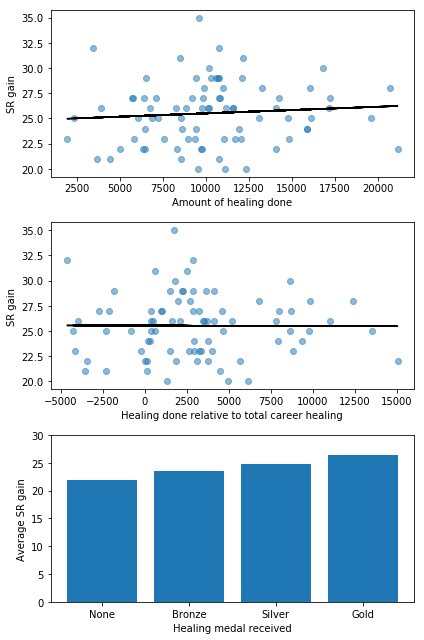

In [11]:
cur_df = df[(df['season'] == 9) & (df['Result']=='Win')]

# get only the games where I played support
support_idx = (cur_df['Role 1'] == 'Support') | (cur_df['Role 2'] == 'Support')
cur_df = cur_df[support_idx]
heal_medal = cur_df.groupby('Heal_medal')['SR Change'].mean().sort_values()

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,9))

ax[0].scatter(cur_df['Heal'], cur_df['SR Change'], alpha=0.5)
fit = np.polyfit(cur_df['Heal'], cur_df['SR Change'], deg=1)
ax[0].plot(cur_df['Heal'], fit[0] * cur_df['Heal'] + fit[1], color='k')
ax[0].set_xlabel('Amount of healing done')
ax[0].set_ylabel('SR gain')

ax[1].scatter(cur_df['Heal'] - cur_df['Heal_career'], cur_df['SR Change'], alpha=0.5)
fit = np.polyfit(cur_df['Heal'] - cur_df['Heal_career'], cur_df['SR Change'], deg=1)
ax[1].plot(cur_df['Heal'] - cur_df['Heal_career'], fit[0] * (cur_df['Heal'] - cur_df['Heal_career']) + fit[1], color='k')
ax[1].set_xlabel('Healing done relative to total career healing')
ax[1].set_ylabel('SR gain')

ax[2].bar([0,1,2,3], heal_medal)
ax[2].set_yticks(range(0,35,5))
ax[2].set_xticks([0,1,2,3])
ax[2].set_xticklabels(heal_medal.index)
ax[2].set_xlabel('Healing medal received')
ax[2].set_ylabel('Average SR gain')

plt.tight_layout()
plt.show()

Overall, it seems there is a relationship between how much healing you do and how much SR you gain after winning a game. This is clearest when looking at the healing medal received. There are of course other factors that determine how much healing you're able to do in a single game (e.g. how many times you died, which character you played), but the positive trend suggests that individual performance does have an influence on SR changes.

## Do deaths affect SR gain?

Dying during a game is one of the worst things that can happen as you cannot contribute to team fights, thus increasing the likelihood of losing the match. But does the number of times you die also affect how much SR you gain after winning a game? For that, we can plot number of deaths in a game against the SR change for that game (the following is for won games only).

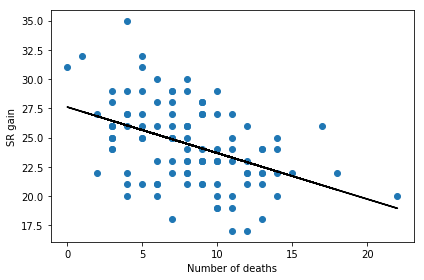

In [12]:
cur_df = df[(df['season'] == 9) & (df['Result']=='Win')]
idx = np.isfinite(cur_df['Death']) & np.isfinite(cur_df['SR Change'])
cur_df = cur_df[idx]

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(cur_df['Death'], cur_df['SR Change'])
fit = np.polyfit(cur_df['Death'], cur_df['SR Change'], deg=1)
ax.plot(cur_df['Death'], fit[0] * cur_df['Death'] + fit[1], color='k')
ax.set_xlabel('Number of deaths')
ax.set_ylabel('SR gain')

plt.tight_layout()
plt.show()

There seems to be a very clear relationship: the more times you die in a game the less SR you gain for a win. So stop dying!

Now, causality isn't clear here, because the more you die the less you can contribute to team fights, and it's possible that it's the reduction in contribution that's causing the reduced SR gain. We can map a sequential colormap to the points to see whether there's a relationship between deaths, SR gain, and contribution (healing done in this case)

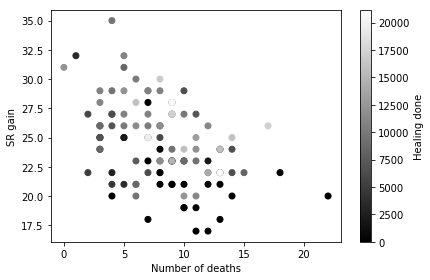

In [13]:
cur_df = df[(df['season'] == 9) & (df['Result']=='Win')]
idx = np.isfinite(cur_df['Death']) & np.isfinite(cur_df['SR Change'])
cur_df = cur_df[idx]

fig, ax = plt.subplots(nrows=1, ncols=1)

p = ax.scatter(cur_df['Death'], cur_df['SR Change'], c=cur_df['Heal'], cmap='gray')
ax.set_xlabel('Number of deaths')
ax.set_ylabel('SR gain')

plt.tight_layout()
cb = plt.colorbar(p)
cb.set_label('Healing done')
plt.show()

If increased number of deaths is causing reduced healing contribution we should see a left-to-right gradient that is coloured white-to-black (i.e. if you die a lot you'll do less healing). However, this doesn't seem to be the case, which suggests that deaths and contribution are not related. Instead, what we see is more of a bottom-to-top gradient that goes black-to-white. This suggests that the more healing you do, the more SR you gain after a win, which supports the analysis in the previous section.

However, a confound here is match duration. It's likely (and intuitive) that you'll simply die more during longer matches, which is supported in the following graph, where longer matches are associated with more deaths.

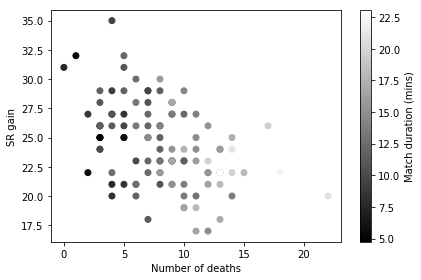

In [14]:
cur_df = df[(df['season'] == 9) & (df['Result']=='Win')]
idx = np.isfinite(cur_df['Death']) & np.isfinite(cur_df['SR Change'])
cur_df = cur_df[idx]

fig, ax = plt.subplots(nrows=1, ncols=1)

p = ax.scatter(cur_df['Death'], cur_df['SR Change'], c=cur_df['match_mins'], cmap='gray')
ax.set_xlabel('Number of deaths')
ax.set_ylabel('SR gain')

plt.tight_layout()
cb = plt.colorbar(p)
cb.set_label('Match duration (mins)')
plt.show()

We need to control for match duration in some way as it has a very direct relationship with number of deaths. So instead of looking at *total* number of deaths, we can calculate number of deaths *per minute* to factor out the confounding effect of match duration, and see how that is related to SR gain and healing done.

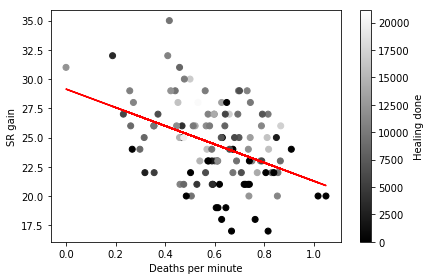

In [15]:
# calculate deaths per minute
df['deaths_per_min'] = df['Death'] / df['match_mins']

cur_df = df[(df['season'] == 9) & (df['Result']=='Win')]
idx = np.isfinite(cur_df['deaths_per_min']) & np.isfinite(cur_df['SR Change'])
cur_df = cur_df[idx]

fig, ax = plt.subplots(nrows=1, ncols=1)

p = ax.scatter(cur_df['deaths_per_min'], cur_df['SR Change'], c=cur_df['Heal'], cmap='gray')
fit = np.polyfit(cur_df['deaths_per_min'], cur_df['SR Change'], deg=1)
ax.plot(cur_df['deaths_per_min'], fit[0] * cur_df['deaths_per_min'] + fit[1], color='r')
ax.set_xlabel('Deaths per minute')
ax.set_ylabel('SR gain')

plt.tight_layout()
cb = plt.colorbar(p)
cb.set_label('Healing done')
plt.show()

After accounting for match duration, we still see the same relationships as before. The more frequently you die the less SR you gain after a win. Furthermore, frequency of deaths is not related to total healing contribution during the match, and better individual performance (increased healing) is associated with larger SR gains.